In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster


### Presentación del dataset

In [2]:
df=pd.read_csv("./datos_luz.csv")
#Vemos como se han cargado y el tipo de cada columna 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   52608 non-null  int64  
 1   Time         52608 non-null  object 
 2   Demand       52608 non-null  float64
 3   Temperature  52608 non-null  float64
 4   Date         52608 non-null  object 
 5   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 2.1+ MB


In [3]:
df

,Unnamed: 0,Time,Demand,Temperature,Date,Holiday
0,0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True
...,...,...,...,...,...,...
52603,52603,2014-12-31T10:30:00Z,3873.448714,19.00,2014-12-31,False
52604,52604,2014-12-31T11:00:00Z,3791.637322,18.50,2014-12-31,False
52605,52605,2014-12-31T11:30:00Z,3724.835666,17.70,2014-12-31,False
52606,52606,2014-12-31T12:00:00Z,3761.886854,17.30,2014-12-31,False


### Exploración de los datos

In [4]:
#Hamos algunos arreglos y eliminamos las columnas que no nos interesen para el estudio
df=df.drop(["Unnamed: 0","Date"],axis=1)
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%dT%H:%M:%SZ')
df=df.drop(["Temperature"],axis=1)

In [5]:
#Determinamos las horas en punto para el estudio y dado que hay muchos datos tomaremos 2 años naturales.
df=df.set_index("Time")
df=df.sort_index()
df=df.resample(rule="H",closed="left",label="right").mean()
df=df.loc['2012-01-01 00:00:00': '2013-12-30 23:00:00']

In [6]:
df

,Demand,Holiday
Time,,
2012-01-01 00:00:00,4329.049863,True
2012-01-01 01:00:00,4685.820480,True
2012-01-01 02:00:00,5009.466997,True
2012-01-01 03:00:00,5270.116328,True
2012-01-01 04:00:00,5487.388289,True
...,...,...
2013-12-30 19:00:00,3174.802000,False
2013-12-30 20:00:00,3384.670765,False
2013-12-30 21:00:00,3728.727804,False


2021-11-26 11:54:58,162 numexpr.utils INFO  NumExpr defaulting to 8 threads.


Text(0.5, 1.0, 'Consumo total distribuido en meses')

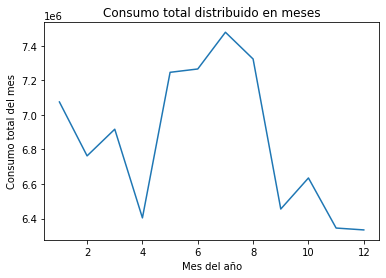

In [7]:
#Vamos a ver como se distribuyen los datos segun meses, días, horas y la influencia de la festividad o no
df['mes'] = df.index.month
mensualidad=[]
for i in range(12):
    mensualidad.append(df.loc[df["mes"]==i+1,"Demand"].sum())     
plt.plot(df["mes"].unique(),mensualidad)
plt.xlabel("Mes del año")
plt.ylabel("Consumo total del mes")
plt.title("Consumo total distribuido en meses")

Podemos observar claramente que en los meses veraniegos la demanda de energía crece.

Text(0.5, 1.0, 'Consumo total distribuido en días de la semana')

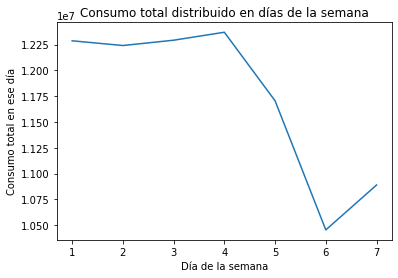

In [8]:
df['dia'] = df.index.day_of_week +1
diario=[]
for i in range(7):
    diario.append(df.loc[df["dia"]==i+1,"Demand"].sum()) 
a=sorted(df["dia"].unique().tolist())

plt.plot(a,diario)
plt.xlabel("Día de la semana")
plt.ylabel("Consumo total en ese día")
plt.title("Consumo total distribuido en días de la semana")

Podemos ver que tanto los viernes como los fines de semana podemos pensar que la gente está menos en casa ya que la demanda de energía baja drásticamente estos días

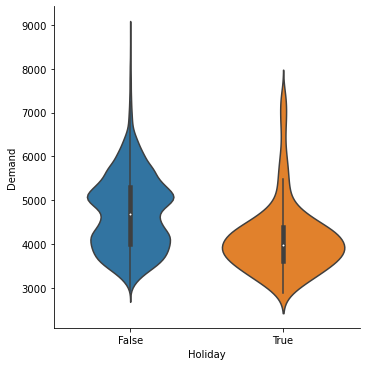

In [9]:
sns.catplot(x = "Holiday", y = "Demand", data = df, kind = "violin")

Con el gráfico del violín podemos ver como los días festivos la demanda suele ser más estable y menor que en los días no festivos.

In [10]:
#Realizamos ahora los gráficos de correlación y autocorrelación parcial

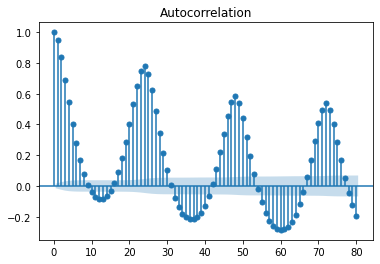

In [11]:
grafico1=plot_acf(df.Demand, lags=80)

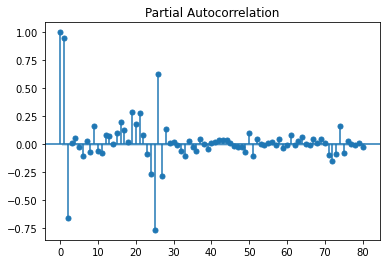

In [12]:
grafico2=plot_pacf(df.Demand, lags=80)

Viendo las gráficas podemos ver claramente que tenemos autocorrelación y autocorrelación parcial lo que nos quiere decir que el consumo en una hora determinada está influida por las horas anteriores y por la demanda de otros días a esa hora.

Por otro lado, cabe mencionar que la temperatura seguramente sea un término que también influya, no obstante como nuestro objetivo va a ser realizar predicciones no vamos a tener los valores futuros de temperatura por lo que no vamos a tenerlo en cuenta

### Preprocesamiento de datos

In [13]:
#En primer lugar cambiamos la variable booleana Holiday a valores enteros
df.loc[:,"Holiday"] = df["Holiday"].astype(int)

In [14]:
#Separación en datos de entrenamiento y de test
#Entrenamiento
df_train=df.loc[:"2013-08-31 23:00:01",:]

#Test(Serán nuestras predicciones)
df_test=df.loc["2013-9-1 00:00:00":, :]


### Entrenamiento del modelo

In [15]:
fore= ForecasterAutoreg(regressor = Ridge(normalize=True, alpha=0.005), lags= [1,2,5,10,15,20,30,45,60])

fore.fit(y=df_train["Demand"], exog=df_train["Holiday"])

In [16]:
#Realizamos ahora las predicciones
metrica,prediccion= backtesting_forecaster(forecaster=fore, y= df["Demand"], exog= df["Holiday"],
                                       steps=24, metric="mean_absolute_error", 
                                          initial_train_size=len(df_train))

In [17]:
print("Obtenemos un error absoluto medio de -> {}".format(metrica))

Obtenemos un error absoluto medio de -> [378.04940238]


### Evaluación de resultados

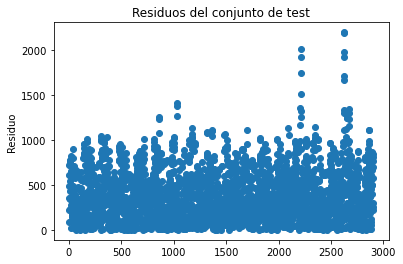

In [18]:
def residuos(y,y_pred):
    diff=abs(y-y_pred)
    return diff
res = residuos(df_test["Demand"],prediccion)


Xtest_res=np.arange(len(prediccion))
plt.figure()
plt.ylabel("Residuo")
plt.title("Residuos del conjunto de test")

plt.scatter(Xtest_res,res)

plt.show()

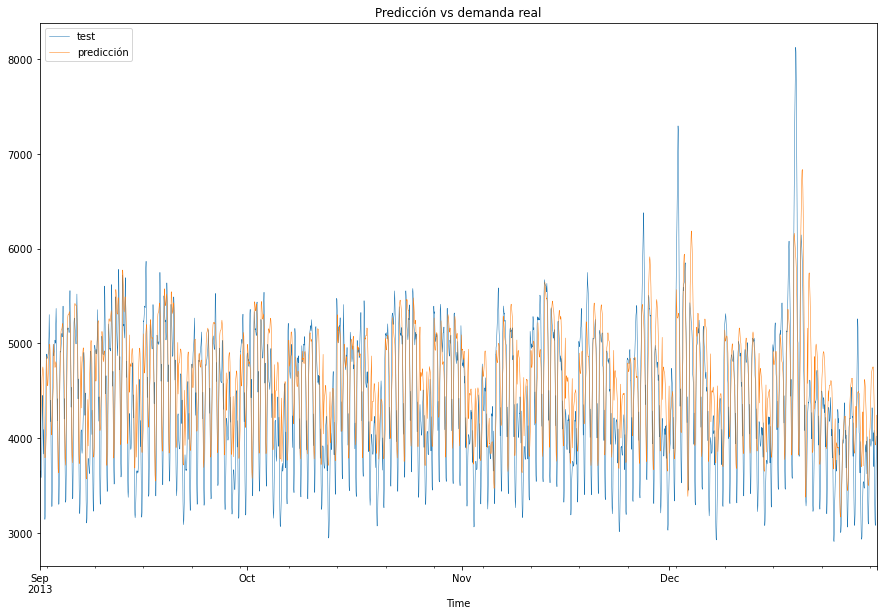

In [19]:
prediccion = pd.Series(data=prediccion, index=df_test["Demand"].index)

fig, ax = plt.subplots(figsize=(15, 10))
df_test["Demand"].plot(linewidth=0.5, label='test')
prediccion.plot(linewidth=0.5, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend()

In [20]:
#Vamos a separar mensualmente las predicciones para obtener una mejor vista
septiembre=df_test[df_test["mes"]==9]
octubre=df_test[df_test["mes"]==10]
noviembre=df_test[df_test["mes"]==11]
diciembre=df_test[df_test["mes"]==12]

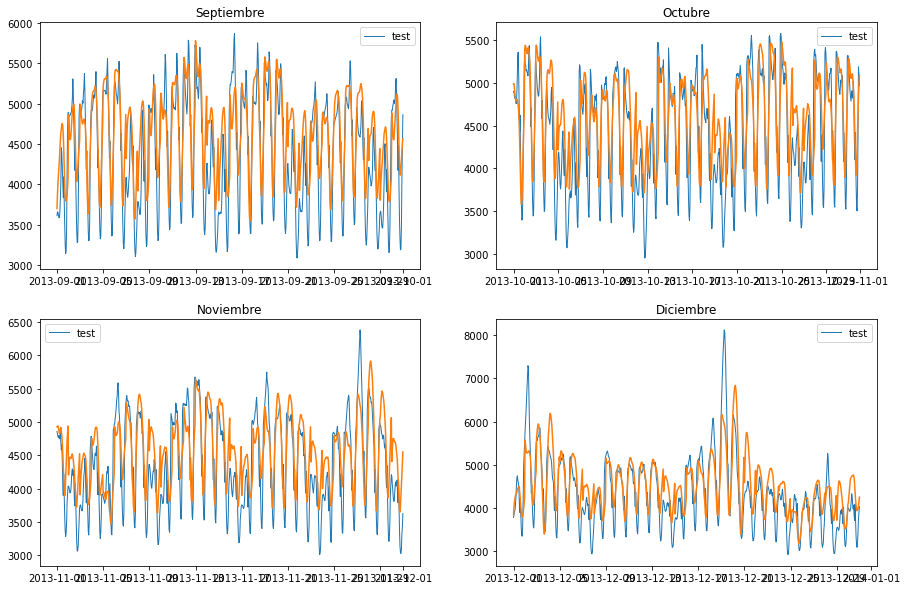

In [21]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
ax[0,0].plot(septiembre["Demand"],linewidth=1.0, label='test')
ax[0,0].plot(prediccion[septiembre.index])
ax[0,0].set_title('Septiembre')
ax[0,0].legend()

ax[0,1].plot(octubre["Demand"],linewidth=1.0, label='test')
ax[0,1].plot(prediccion[octubre.index])
ax[0,1].set_title('Octubre')
ax[0,1].legend()

ax[1,0].plot(noviembre["Demand"],linewidth=1.0, label='test')
ax[1,0].plot(prediccion[noviembre.index])
ax[1,0].set_title('Noviembre')
ax[1,0].legend()

ax[1,1].plot(diciembre["Demand"],linewidth=1.0, label='test')
ax[1,1].plot(prediccion[diciembre.index])
ax[1,1].set_title('Diciembre')
ax[1,1].legend()